# Finding Centroids
This notebook is a follow up of the notebook ilastik/pixels_classification_multiple_channels
We segment our images using the probability images obtained by ilastik and find the centroids of our objects.
TODO: describe the goal of the analysis

## Prepare the analysis
First of all, we need to import the libraries that we are going to use

In [1]:
import numpy as np
from Python import toolbox
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from getpass import getuser, getpass

And define a number of variables that we are going to use in the analysis

In [2]:
RAW_DATASET_ID = 151
PROBABILITIES_DATASET_ID = 301
OMERO_SERVER = 'localhost'
# RAW_DATASET_ID = 3248  # the ID if the dataset containing th raw images
# PROBABILITIES_DATASET_ID = 3264  # the ID of the dataset containing the probability images obtained by ilastik
# OMERO_SERVER = 'demo.openmicroscopy.org' # the URL of our OMERO server
PORT = 4064  # the port to connect to. Default is 4046
USER = input('Username: ')
PASSWORD = getpass()
GROUP = None  # the group where the data is stored

## Explore your data
Now we can connect to OMERO, get some information on the dataset that we want to analyze and explore the data.

All the data is arranged in two datasets in the same project. One dataset contains the raw images and the other one 
contains the probability images extracted using Ilastik.

In [3]:
# Create a connection
conn = toolbox.open_connection(username=USER, password=PASSWORD, group=GROUP,
                               host=OMERO_SERVER, port=PORT)
print(f'Connection successful: {conn.isConnected()}')

# Get all the images contained in the raw dataset
raw_dataset = toolbox.get_dataset(connection=conn, dataset_id=RAW_DATASET_ID)
raw_images = toolbox.get_dataset_images(dataset=raw_dataset)
raw_images = list(raw_images)

# ... and in the probabilities dataset
prob_dataset = toolbox.get_dataset(connection=conn, dataset_id=PROBABILITIES_DATASET_ID)
prob_images = toolbox.get_dataset_images(dataset=prob_dataset)
prob_images = list(prob_images)

print('RAW IMAGES')
for image in raw_images[:3]:
    print(f'{image.getName()} Dimensions(z, c, t, x, y): {image.getSizeZ()}, {image.getSizeC()}, {image.getSizeT()}, {image.getSizeX()}, {image.getSizeY()}')

print('PROBABILITY IMAGES')
for image in prob_images[:12]:
    print(f'{image.getName()} Dimensions(z, c, t, x, y): {image.getSizeZ()}, {image.getSizeC()}, {image.getSizeT()}, {image.getSizeX()}, {image.getSizeY()}')
    

Connection successful: True
RAW IMAGES
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position001] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position002] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position003] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
PROBABILITY IMAGES
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch1_Probabilities.npy Dimensions(z, c, t, x, y): 30, 2, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch2_Probabilities.npy Dimensions(z, c, t, x, y): 30, 2, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch3_Probabilities.npy Dimensions(z, c, t, x, y): 30, 2, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_

You should see 
- a few of the raw images: 3-D stacks of 4 channels (DAPI, X1, X2 and X3) and
- one probability image per each channel in the raw images : 3-D stacks of 2 channels representing the probability of being Foreground (channel 0) and the probability of being Background (channel 1)

You may generate here a URL to access any of the images and have a look at them

In [4]:
print('For the raw images go to:')
print(f'http://{OMERO_SERVER}:8080/webclient/img_detail/{raw_images[0].getId()}/')
print('For the probability images go to:')
print(f'http://{OMERO_SERVER}:8080/webclient/img_detail/{prob_images[0].getId()}/')

For the raw images go to:
http://localhost:8080/webclient/img_detail/101/
For the probability images go to:
http://localhost:8080/webclient/img_detail/254/


### Exploring the raw values
You may load an image as a numpy array ...

In [5]:
raw_data = toolbox.get_5d_stack(raw_images[0])

... and see the raw values


In [7]:
# The dimensions are stored in the following order (z, c, t, x, y)
print(raw_data.shape)

(30, 4, 1, 1576, 1576)


In [9]:
print(raw_data[14,          # z plane 15. Note that in 0 based indexing the 15th element is referred by 14
               2,           # channel 3
               0,           # time point 0
               1100:1120,   # x pixels in the format from:until_but_excluded
               90:100]      # for example from pixel 90 until pixel 100 (the pixel at position 100 is excluded)
      )

[[ 66  66 132 265  66 199  66 199 199  66]
 [  0   0   0 132 132  66 132 398 132  66]
 [ 66 265 132 132  66  66 132 132  66   0]
 [265 265  66  66 331 199  66  66  66  66]
 [199 132  66  66 265   0 132   0  66 199]
 [  0   0  66 265 132 199   0 199 199 199]
 [ 66 132 199 199 199 331 199 265 199 132]
 [199 265 132 265 265 132 199  66 132   0]
 [  0 132  66 132   0 265  66 132  66   0]
 [265 199  66   0  66  66 199 132 265   0]
 [  0 265  66 265 132 199 331 132  66 132]
 [132 331  66 265  66   0  66  66   0  66]
 [265   0 132  66 199 132  66  66   0  66]
 [ 66  66 199  66 132   0 199 132  66   0]
 [  0  66 132  66   0 265  66 132  66 132]
 [ 66  66  66  66 132   0  66 132  66   0]
 [ 66   0   0 199   0 132   0 265 199   0]
 [331   0   0  66   0   0   0  66 132   0]
 [ 66   0  66   0   0  66  66   0  66  66]
 [ 66   0 199   0   0 132   0   0   0  66]]


This raw_data object is a **_Numpy ndarray_** (n-dimensional array). 
This is Python's way to work very efficient with image data.

### Visualizing Numpy arrays
You may have a more convenient visualization of these data by using any of the python plotting libraries.
Python's standard library includes matplotlib. We imported previously *matplotlib.pyplot* as *plt* so let's use of it.

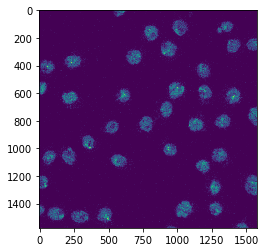

In [19]:
# We create a plot of a fraction of the image, the DAPI (0) channel for example in plane 10
plt.imshow(raw_data[15, 0, 0, :, :])  # Observe the notation ':' for indexing. That means 'take everything'

# Creating the plot just creates it but you always have to show it
plt.show()

matplotlib may create very complex publication-ready plots. You may have a look at what you may do in [here](https://matplotlib.org/gallery.html).

## Running the analysis
Before moving further we have to arrange the images in the two lists so that every raw image has 4 probability images, one per channel.

In [20]:
# We are going to create a list of secondary lists where every secondary list 
# contains the probability images for one single raw image
rearranged_prob_images = list()
for raw_image in raw_images:  # We are looping through every raw image
    name = raw_image.getName()
    # We have to remove all the extra characters introduced by Leica. 
    # Not necessary in principle but as we did it for the probabilities we have to do it again
    name = name.replace('/', '_')
    name = name.replace('.lif [', '_')
    name = name.replace(']', '')
    
    rearranged_prob_images.append(list())  # We append an empty secondary list
    for subfix in ['DAPI_Probabilities',
                   'DAPI_Ch1_Probabilities',
                   'DAPI_Ch2_Probabilities',
                   'DAPI_Ch3_Probabilities']:
        for prob_image in prob_images:
            if name in prob_image.getname() and subfix in prob_image.getname():
                rearranged_prob_images[-1].append(prob_image)
                
# We don't need to keep two lists of probability images
# so we just replace the old list with the new one
prob_images = rearranged_prob_images

Always good to double check...

In [21]:
for i in range(5):
    print(raw_images[i].getName())
    for p in prob_images[i]: print(p.getName())

20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position001]
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch1_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch2_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch3_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position002]
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position002_DAPI_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position002_DAPI_Ch1_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position002_DAPI_Ch2_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position0

## Analyzing the images
Now we have everything ready to start our image analysis. We want to:
- Segment each channel using the probability values extracted by Ilastik in stead of the raw values.
- Save that segmentation into OMERO.
- While we still have the images in memory, we would like to calculate the centroids of the spots this time 
using the raw pixel values.
- We will save the centroid coordinates as a table associated to every image.

For most of the image analysis we are going to use scikit-image, a python iamge analysis library built on top of numpy.

In [ ]:
# We create here a small widget to follow the progress
progress = widgets.IntProgress(value=0, min=0, max=len(raw_images)*4, description='Progress:')
display(progress)

# We loop through every image in the raw images list
for index, raw_image in enumerate(raw_images[:1]):
    raw_data = toolbox.get_5d_stack(raw_image)  # We get the raw data. Order is zctxy
    
    # We now loop through every channel
    for ch_nr, ch_prob_image in enumerate(prob_images[index]):
        ch_prob_data = toolbox.get_5d_stack(ch_prob_image)
        
        labels = toolbox.segment_channel(channel=ch_prob_data[:,0,0,:,:].squeeze(),  # We only want to segment on the probability of being foreground
                                         min_distance=1,
                                         sigma=None,
                                         method='hysteresis',
                                         hysteresis_levels=(.5, .9))
        
        # the labels object contains now the segmentation masks for every found object
        properties, positions = toolbox.compute_channel_spots_properties(raw_data[:,ch_nr,:,:,:].squeeze(),
                                                                         labels)
        
        # Update the progress bar
        progress.value = 1 + (index * ch_nr)

IntProgress(value=0, description='Progress:', max=48)

In [36]:
conn.close()
